In [5]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
import pickle

In [11]:
data_path = '../../data/tfidf_umap/'

In [12]:
fandom_list = [i for i in os.listdir(data_path) if '.p' in i]

In [13]:
fandom_list

['tolkien_j_r_r_works_&_related_fandoms_2013-03.p',
 'one_direction_2013-07.p',
 'les_miserables_all_media_types_2013-06.p',
 'sherlock_holmes_&_related_fandoms_2013-04.p',
 'shakespare_william_works_2014-09.p',
 'arthurian_mythology_&_related_fandoms_2013-03.p',
 'buffy_the_vampire_slayer_2013-05.p',
 'the_walking_dead_&_related_fandoms_2013-02.p',
 'dragon_age_all_media_types_2013-06.p',
 'supernatural_2013-04.p',
 'haikyuu_2014-11.p',
 'attack_on_titan_2013-09.p',
 'star_wars_all_media_types_2013-04.p',
 'hamilton_miranda_2016-03.p',
 'ms_paint_adventures_2013-02.p',
 'kuroko_no_basuke_2013-06.p',
 'naruto_2013-01.p',
 'bishoujo_senshi_sailor_moon_2013-09.p',
 'hetalia_axis_powers_2013-05.p',
 'harry_potter_2013-03.p',
 'dcu_2013-02.p',
 'doctor_who_&_related_fandoms_2013-05.p']

### clustering

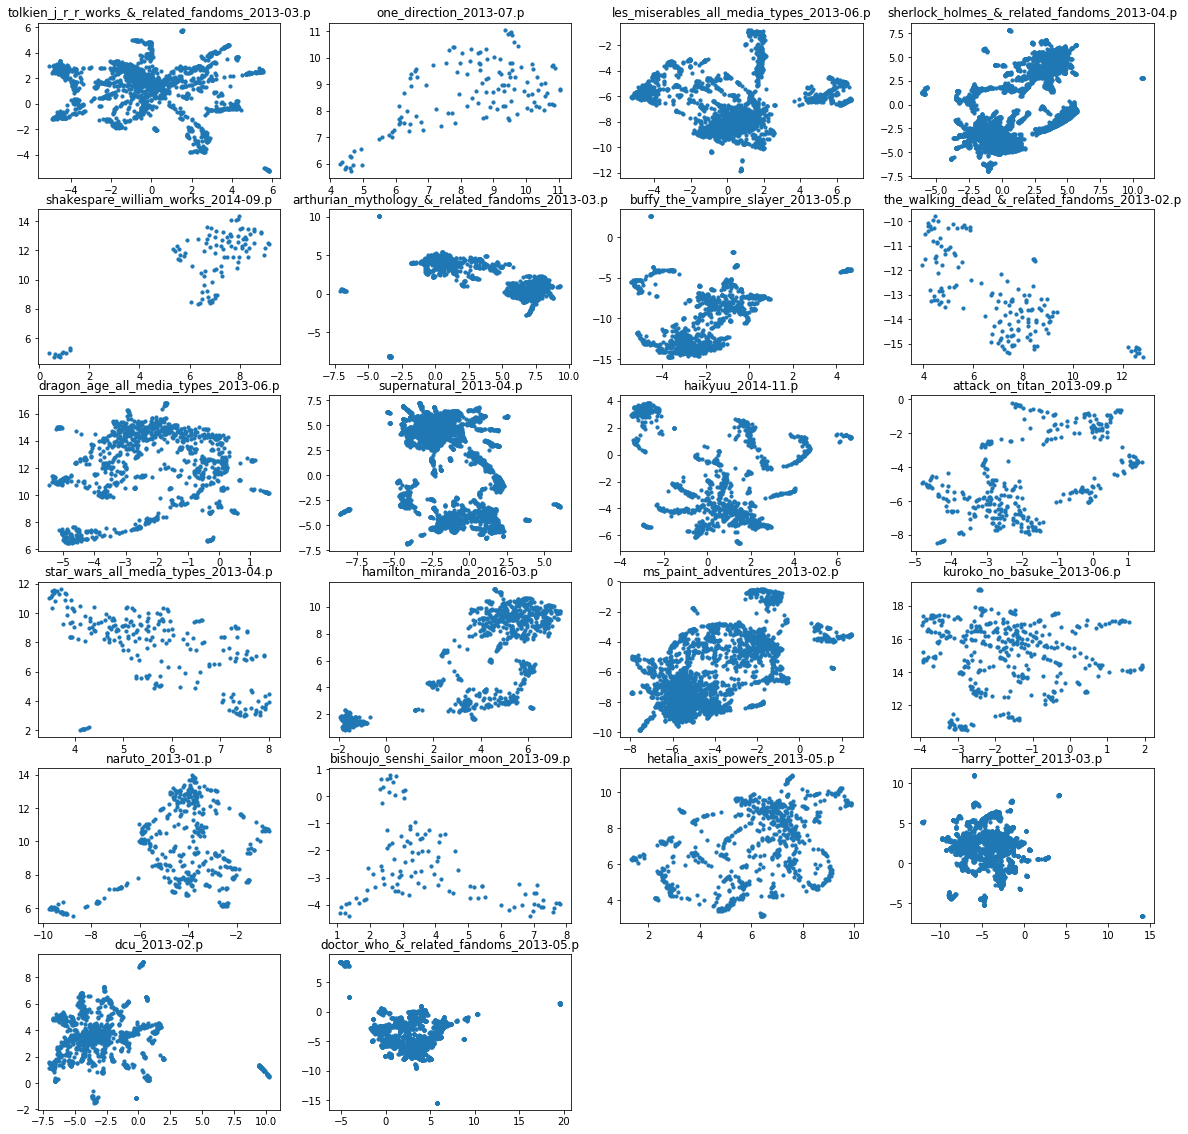

In [17]:
plt.figure(figsize = (20,20))
for i,fandom in enumerate(fandom_list):

    vecs = pickle.load(open(os.path.join(data_path,fandom), 'rb'))
    plt.subplot(6,4,i+1)
#     norm = colors.Normalize(vmin = kmin, vmax = kmax)
    plt.scatter(vecs[:, 0], vecs[:, 1], s=10)
    plt.title(fandom)
plt.savefig('umap.png', type='png')


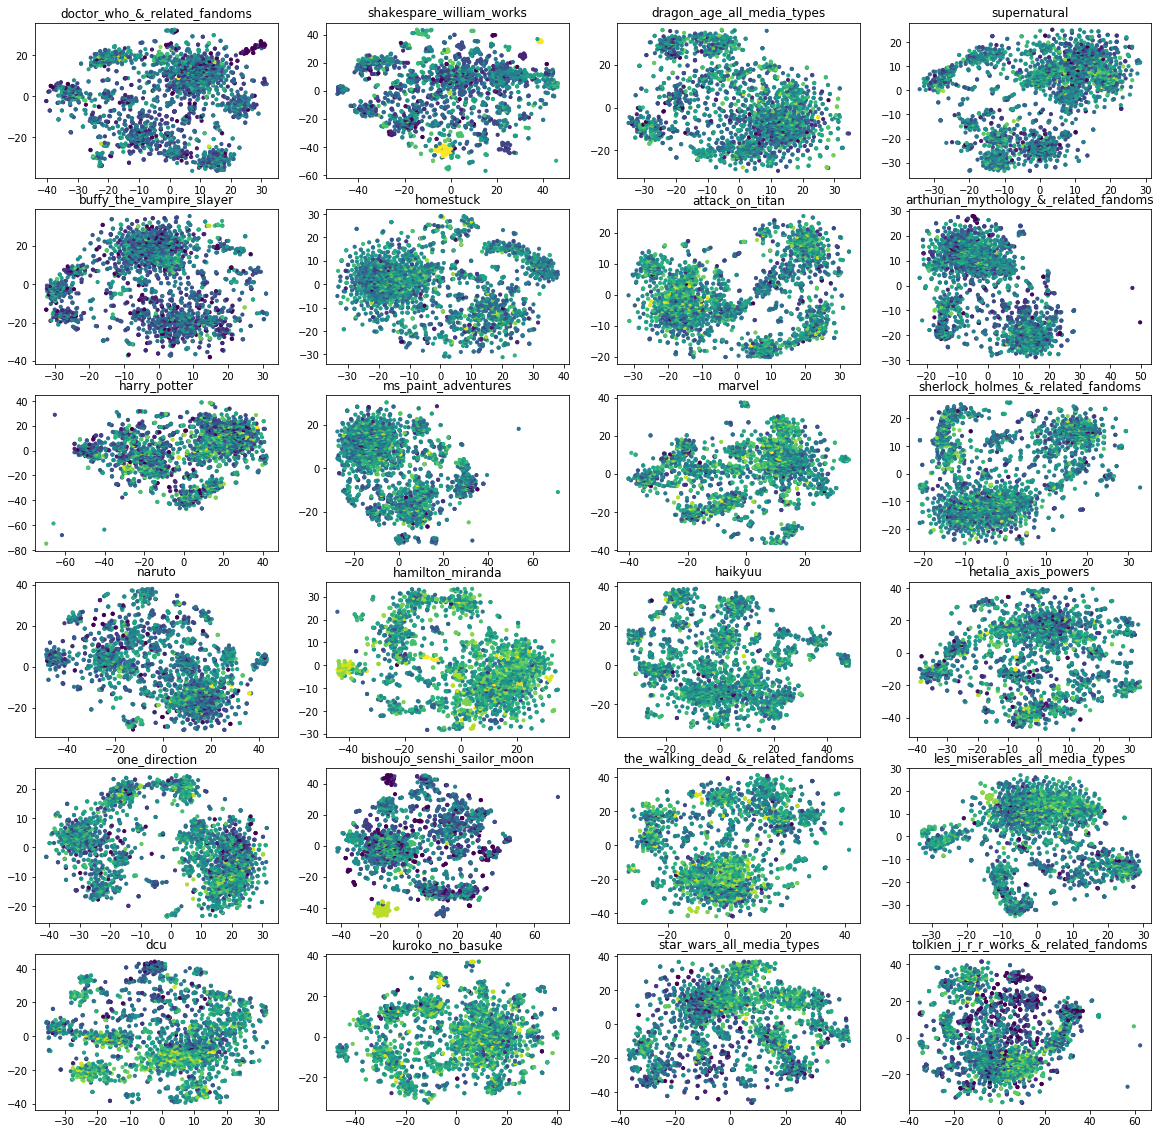

In [32]:
# color w Kudos
plt.figure(figsize = (20,20))
for i,fandom in enumerate(fandom_list):

    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    df = df.sort_values(by = "pc1")[15:-15]
    df = df.sort_values(by = "pc2")[15:-15]
    df['Kudos'] = np.log(df['Kudos']+1/df['Chapters'])
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    kmin = min(df['Kudos'])
    kmax = max(df['Kudos'])
    
    plt.subplot(6,4,i+1)
    norm = colors.Normalize(vmin = kmin, vmax = kmax)
    plt.scatter(df['pc1'], df['pc2'], c=df['Kudos'], norm = norm, cmap = 'viridis', s = 10)
    plt.title(fandom.replace('_tfidf_tsne.tsv', ''))
    plt.savefig('tsne_plot_rmoutliers.pdf', type='pdf')


### Look at the fics

In [ ]:
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    plt.figure()
    plt.scatter(df['pc1'], df['pc2'],alpha=0.7,c='blue')
    l = 0
    for label, x, y in zip(df['URL'], df['pc1'], df['pc2']):
        r = random.randint(0,100)
        if r % 50 == 0:
            plt.annotate(l, xy = (x,y),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
            print(l, ":", label)
            l += 1

    plt.title(fandom)
    break

In [ ]:
def find_close(vec, df):
    min_dist = (0,1)
    for row in df.iterrows():
        row_vec = [row[1]['pc1'], row[1]['pc2']]
        if vec != row_vec:
            if spatial.distance.cosine(vec,row_vec) < min_dist[1]:
                min_dist = (row[0], spatial.distance.cosine(vec,row_vec))
    return min_dist

In [ ]:
df.columns.values

In [ ]:
df['closest'] = df.apply(lambda row: find_close([row['pc1'], row['pc2']], df), axis=1 )

In [ ]:
df.head(2)

In [ ]:
df.iloc[2].URL

### Look at the overrepresented words

In [ ]:
def logodds(corpora_dic, bg_counter):
    """ It calculates the log odds ratio of term i's frequency between 
    a target corpus and another corpus, with the prior information from
    a background corpus. Inputs are:
    
    - a dictionary of Counter objects (corpora of our interest)
    - a Counter objects (background corpus)
    
    Output is a dictionary of dictionaries. Each dictionary contains the log 
    odds ratio of each word. 
    
    """
    corp_size = dict([(c, sum(corpora_dic[c].values())) for c in corpora_dic])
    bg_size = sum(bg_counter.values())
    result = dict([(c, {}) for c in corpora_dic])
    
    for name, c in corpora_dic.items():
        for word in c:
            #if 10 > sum(1 for corpus in corpora_dic.values() if corpus[word]):
            #    continue
            
            fi = c[word]
            fj = sum(co[word] for x, co in corpora_dic.items() if x != name)
            fbg = bg_counter[word]
            ni = corp_size[name]
            nj = sum(x for idx, x in corp_size.items() if idx != name)
            nbg = bg_size
            oddsratio = log(fi+fbg) - log(ni+nbg-(fi+fbg)) -\
                        log(fj+fbg) + log(nj+nbg-(fj+fbg))
            std = 1.0 / (fi+fbg) + 1.0 / (fj+fbg)
            z = oddsratio / sqrt(std)
            result[name][word] = z
            
    return result

In [ ]:
text = []
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    for line in df.Text.tolist():
        text.extend(word.lower() for word in line.split())
bg = Counter(text)

In [ ]:
def overrep_words(row, corp_b, bg):
    text = [word.lower() for word in row.split()]
    corp_a = Counter(text)
    result = logodds({'fic':corp_a, 'fandom':corp_b}, bg)
#     for k in sorted(result['fic'], key=result['fic'].get, reverse=True):
#         print(k,result['fic'][k])
    return sorted(result['fic'], key=result['fic'].get)[0:20]

In [ ]:
df.columns.values

In [ ]:
for i,fandom in enumerate(fandom_list):
    df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
    df = df.sample(100)
    text = []
    for line in df.Text.tolist():
        text.extend(word.lower() for word in line.split())
    corp_b = Counter(text)
    df['overrep_words'] = df['Text'].apply(lambda x: overrep_words(x, corp_b, bg))
    plt.figure(figsize = (12, 10))
    plt.scatter(df['pc1'], df['pc2'],alpha=0.7,c='blue')
    l = 0
    for label, x, y in zip(df['overrep_words'], df['pc1'], df['pc2']):
        r = random.randint(0,100)
        if r % 10 == 0:
            plt.annotate(l, xy = (x,y),bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
            print(l, ":", label)
            l += 1
    plt.title(fandom)